## Load required libraries and helper tools.

In [1]:
# load libraries:
import requests # library to handle requests for Foursquare.
import numpy as np
import pandas as pd

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans


In [7]:
# Install geopy, the coordinate (latitude, longitude) locator tool for this project.
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

print('geopy installed.')

Solving environment: ...working... done

# All requested packages already installed.

geopy installed.


In [3]:
# Install folium, the map tool for this project.
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map library

print('Libraries for folium done.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries for folium done.


---
<h1>
<div align="center">Coursera IBM Capstone Project - The Battle of Neighborhoods</div>
</h1>

---
<h2>
<div align="center">Where is lunch?</div>  
<div align="center">Jupyter notebook project by Precioso Gabrillo III</div>
</h2>

---
This jupyter notebook creates the steps to disseminate data and display it to determine where to locate a food truck in the city of San Francisco, USA.

The following datasets are used:  
- Commercial real estate prices in US$/squarefoot of vacant space in various city neighborhoods.  
- Food truck vendor locations.  
- Foursquare data of restaurants within the neighborhoods.  

An exploratory data analysis is applied to prepare the data for visual representations of vacant rates and vacant space amount.  A neighborhood map shows the following:  
- vacant sites  
- food truck locations  
- overlay of the vacant sites with the truck locations
- clusters of food trucks within the vacant locations  

Foursquare API obtains the list of restaurants within a specified area in a neighborhood.  The list categorizes the frequent cuisine type within the office vacant site.

The K-Means algorithm clusters the food truck data within the examined neighborhood to indicate where and how many food trucks are within the office space location.  Geopy extracts the coordinates of the neighborhood and food trucks and folium maps the coordinates.

*All datasets are located in the same directory as this notebook.*

---
## Exploratory Data Analysis.
### Load & prepare datasets.  

The first set of data will examine the commercial real estate prices and size.  This data set is from https://42floors.com/research/us/ca/san-francisco.

In [2]:
# Obtain data.
sfdata = '42floors-submarket_data-us-ca-san-francisco-as-of-Mar-12.csv'
sf_cre = pd.read_csv(sfdata)
sf_cre.dropna(inplace=True)

# Rename columns for easy understanding.
sf_cre.rename(columns={'region':'Neighborhood','median_rate':'Median $/sqft','median_size':'Median Vacant Size','listings posted in last 180 days':'Number of listings (past 180 days)'}, inplace=True)

# Sort the data based on the price per area, the key metric.
sf_cre.sort_values(by=['Median $/sqft'], inplace=True, ascending=False)

# Check.
sf_cre.head(9)

,Neighborhood,Median $/sqft,Median Vacant Size,Number of listings (past 180 days)
23,Northern Waterfront,85.00,250.0,231
11,North Beach,78.79,190.0,436
103,Financial District,72.00,110.0,3361
82,Hayes Valley,69.33,450.0,24
33,Downtown San Francisco-Union Square,68.00,330.0,846
5,Northeast San Francisco,64.00,130.0,5882
97,Eureka Valley,60.00,1100.0,1
113,Rincon Hill,58.00,1690.0,139
48,Lower Nob Hill,56.00,1270.0,154


In [8]:
# data size
sf_cre.shape

(33, 4)

In [10]:
# more data prep
sf_cre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 23 to 101
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Neighborhood                        33 non-null     object 
 1   Median $/sqft                       33 non-null     float64
 2   Median Vacant Size                  33 non-null     float64
 3   Number of listings (past 180 days)  33 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


---
#### Clean up data.

In [3]:
# Modify some names because geopy does not have the coordinates, using in lieu.
# The index was not reset because it is easier to identify.  It is only used here.
# These neighborhoods are not registered with geopy but instead geopy's recommend a substitute location name.
#   Northern Waterfront                     > Northeast Waterfront Historic District
#   Downtown San Francisco-Union Square     > Union Square
#   Lower Nob Hill                          > Nob Hill
sf_cre.at[23, 'Neighborhood'] = 'Northeast Waterfront Historic District'
sf_cre.at[33, 'Neighborhood'] = 'Union Square'
sf_cre.at[48, 'Neighborhood'] = 'Nob Hill'

# Remove Bret Harte because it is not located in the city of SF.
sf_cre.drop([101], inplace=True)

# Check again.
sf_cre.head(9)

,Neighborhood,Median $/sqft,Median Vacant Size,Number of listings (past 180 days)
23,Northeast Waterfront Historic District,85.00,250.0,231
11,North Beach,78.79,190.0,436
103,Financial District,72.00,110.0,3361
82,Hayes Valley,69.33,450.0,24
33,Union Square,68.00,330.0,846
5,Northeast San Francisco,64.00,130.0,5882
97,Eureka Valley,60.00,1100.0,1
113,Rincon Hill,58.00,1690.0,139
48,Nob Hill,56.00,1270.0,154


In [13]:
# Ensure size has 1 less entry.
sf_cre.shape

(32, 4)

---
### Show the distribution of each neighborhood and the vacant lease rates.  
The purpose of this study is to use the lease rates as a metric to identify where to anticipate possible new businesses.  There are 2 charts, the first one shows the median price per square foot in each neighborhood.

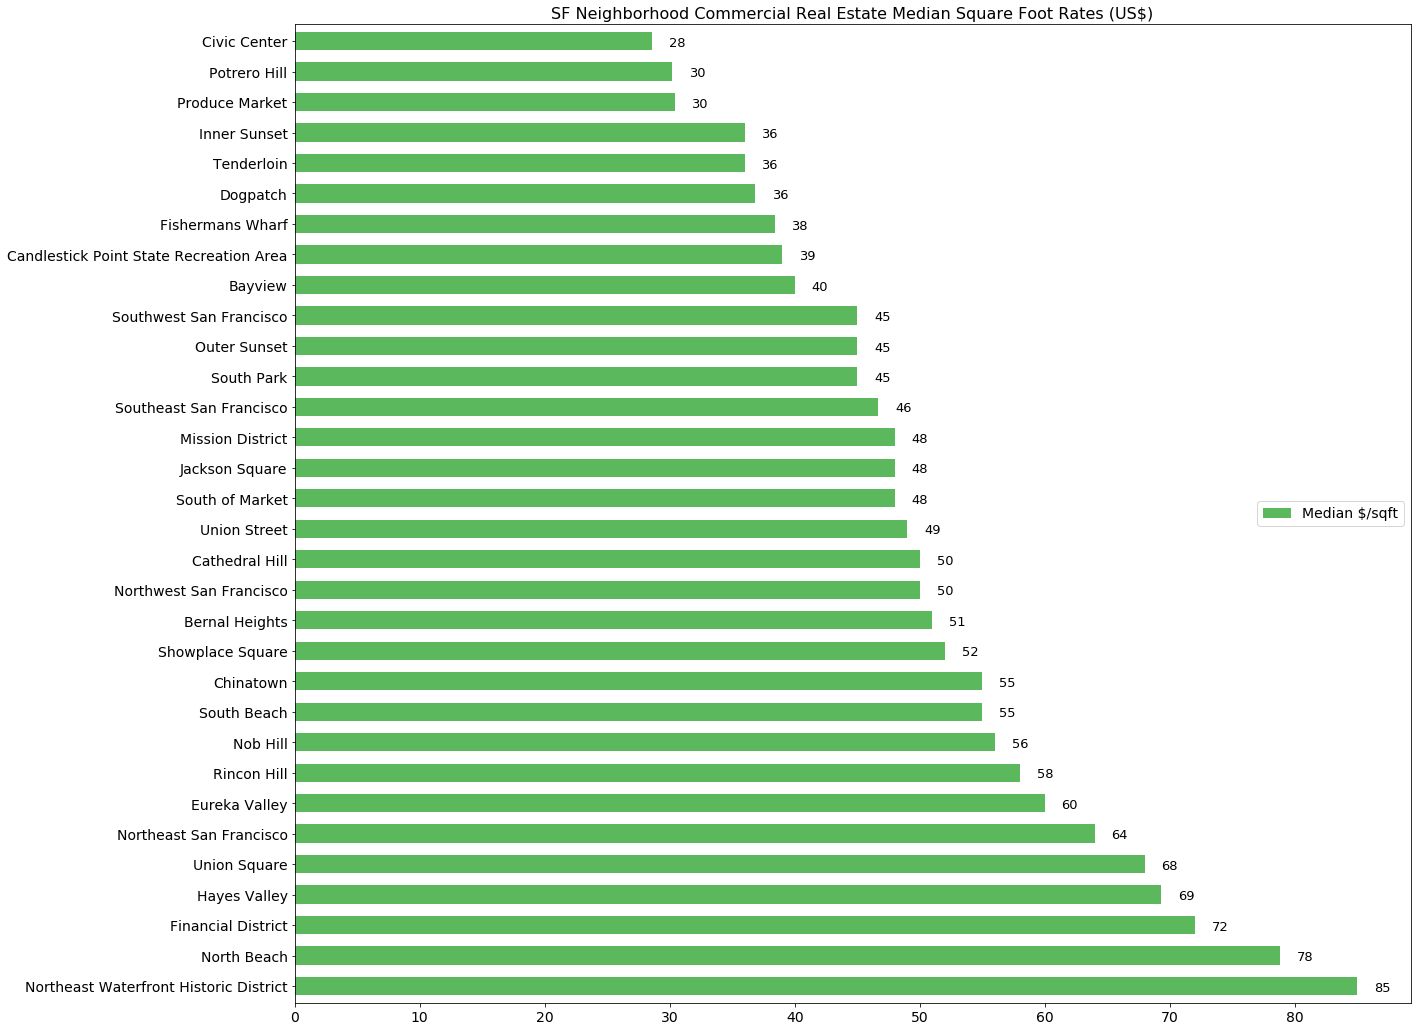

In [31]:
# Obtain the columns for this plot.  Using horizontal bar chart to compare the rates.
sf_cre_rate = sf_cre[ ['Neighborhood', 'Median $/sqft'] ]
sf_cre_rate.set_index('Neighborhood', inplace=True)
sf_cre_rate.head()

# Prepare labels, show the value on the chart.
label_ = sf_cre_rate.index.to_list()
y_pos = np.arange(len(label_))

sf_cre_rate.plot.barh( figsize=(20, 18), width=0.6,
            color='#5cb85c',
            grid=False)
            
plt.title('SF Neighborhood Commercial Real Estate Median Square Foot Rates (US$)', fontsize=16)
plt.legend(fontsize=14, facecolor='white', loc='center right')
plt.xticks(fontsize=14)             # bar label fontsize
plt.yticks(fontsize=14)
ax = plt.axes()
ax.set_facecolor('white')           # chart background
ax.set_yticks(y_pos)
ax.set_yticklabels(label_)
ax.yaxis.set_label_text('')
# Place the labels on the plot.
for i in ax.patches:
    ax.text( i.get_width()+2, i.get_y()+0.26, 
        str(int(i.get_width())), ha='center', va='center',
        fontsize=13)
plt.show() 

This next chart shows the median vacant square footage in the neighborhood, i.e. vacant spaces available for lease/sale.

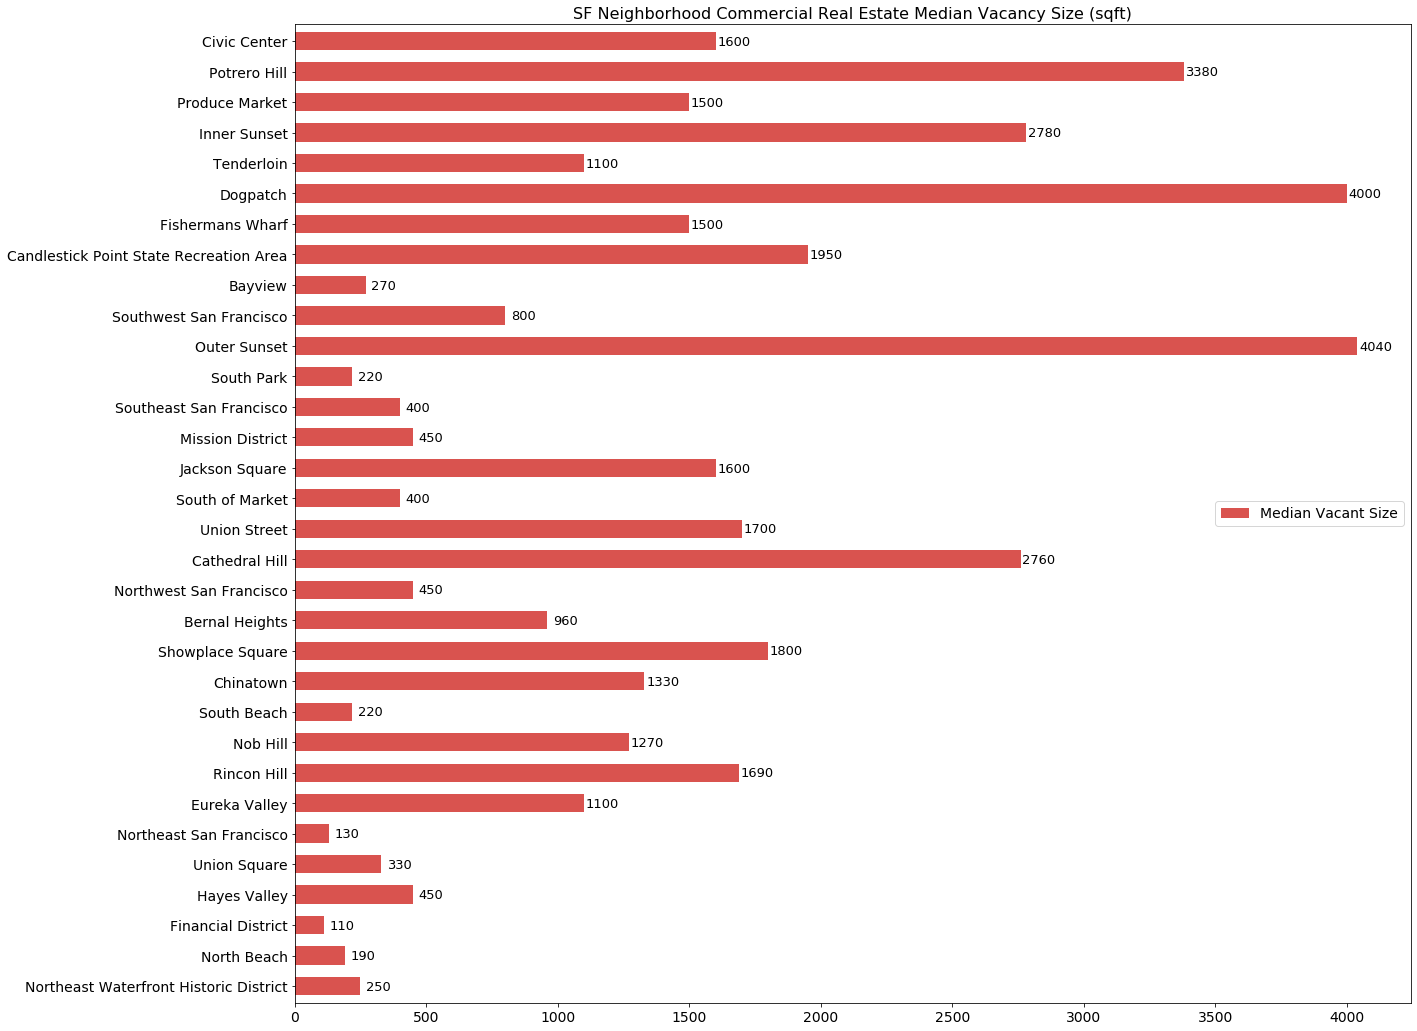

In [16]:
# Using horizontal bar chart, the data is not sorted by value but to keep the list of neighborhoods in the same order as the first chart. 
sf_cre_vact = sf_cre[ ['Neighborhood', 'Median Vacant Size'] ]
sf_cre_vact.set_index('Neighborhood', inplace=True)
sf_cre_vact.head()

# Add labels on the chart.
label_ = sf_cre_vact.index.to_list()
y_pos = np.arange(len(label_))

sf_cre_vact.plot.barh( figsize=(20, 18), width=0.6,
            color='#d9534f',
            grid=False)
            
plt.title('SF Neighborhood Commercial Real Estate Median Vacancy Size (sqft)', fontsize=16)
plt.legend(fontsize=14, facecolor='white', loc='center right')
plt.xticks(fontsize=14)             # bar label fontsize
plt.yticks(fontsize=14)
ax = plt.axes()
ax.set_facecolor('white')           # chart background
ax.set_yticks(y_pos)
ax.set_yticklabels(label_)
ax.yaxis.set_label_text('')
# Place the labels on the plot.
for i in ax.patches:
    ax.text( i.get_width()+69, i.get_y()+0.29, 
        str(int(i.get_width())), ha='center', va='center',
        fontsize=13)
plt.show() 

---
## Food Trucks  
The data comes from DataSF and provided by the Department of Public Works.  It is titled Mobile Food Facility Permit and includes the location of each food truck.  By law, the food truck can only operate at that permitted location for 1 year and must reapply to continue for the following year.  

For this dataset, it will extract the operator name, latitude, & longitude in order to map unto folium.  This will then be overlayed with the neighborhood locations of the office vacancy data.  https://data.sfgov.org/Economy-and-Community/Mobile-Food-Facility-Permit/rqzj-sfat

In [19]:
# The dataset.
mobile_file = 'Mobile_Food_Facility_Permit.csv'
sf_foodtruck = pd.read_csv(mobile_file)
sf_foodtruck.head()

,locationid,Applicant,FacilityType,cnn,LocationDescription,Address,blocklot,block,lot,permit,...,Latitude,Longitude,Schedule,dayshours,NOISent,Approved,Received,PriorPermit,ExpirationDate,Location
0,1334734,Rita's Catering,Truck,9100000,MISSION ST: 06TH ST to 07TH ST (1000 - 1099),1028 MISSION ST,3703033,3703,033,19MFF-00047,...,37.780694,-122.409669,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,07/03/2019 12:00:00 AM,2019-07-03,0,07/15/2020 12:00:00 AM,POINT (-122.409668813219 37.7806943774082)
1,1334819,tacos y pupusas los trinos,NaN,9158000,MISSION ST: AVALON AVE to COTTER ST (4368 - 4439),4384 MISSION ST,6798004,6798,004,19MFF-00048,...,37.727567,-122.432970,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2019-07-03,0,NaN,POINT (-122.432969701989 37.7275665375917)
2,1353225,Treats by the Bay LLC,Truck,7034000,HOWARD ST: MALDEN ALY to 02ND ST (574 - 599),201 02ND ST,3736097,3736,097,19MFF-00111,...,37.786802,-122.397872,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2019-07-31,0,07/15/2020 12:00:00 AM,POINT (-122.397871635003 37.7868016505971)
3,1400796,El Calamar Perubian Food Truck,Truck,1329000,24TH ST: UTAH ST to POTRERO AVE (2600 - 2699),2615 24TH ST,4264019A,4264,019A,20MFF-00002,...,37.752815,-122.405663,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2020-01-27,0,01/31/2021 12:00:00 AM,POINT (-122.405662641918 37.7528148292211)
4,1336685,Mike's Catering,Truck,7200000,INDIANA ST: 26TH ST to CESAR CHAVEZ ST (1500 -...,1575 INDIANA ST,4317017,4317,017,19MFF-00054,...,37.750850,-122.390028,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,07/10/2019 12:00:00 AM,2019-07-10,1,07/15/2020 12:00:00 AM,POINT (-122.390027615501 37.7508496068125)


In [20]:
# CHeck
sf_foodtruck.shape

(652, 24)

In [21]:
# More data check.
sf_foodtruck.count()

locationid             652
Applicant              652
FacilityType           639
cnn                    652
LocationDescription    630
Address                652
blocklot               640
block                  640
lot                    640
permit                 652
Status                 652
FoodItems              644
X                      601
Y                      601
Latitude               652
Longitude              652
Schedule               652
dayshours              211
NOISent                  4
Approved               527
Received               652
PriorPermit            652
ExpirationDate         624
Location               652
dtype: int64

The above count shows some differences particularly in the number between Applicant & Approved.  The Approved column is pertinent to this study because that is where the truck is permitted to operate.

In [22]:
sf_foodtruck['Approved'].head()

0    07/03/2019 12:00:00 AM
1                       NaN
2                       NaN
3                       NaN
4    07/10/2019 12:00:00 AM
Name: Approved, dtype: object

The above shows missing data.  Missing data can only mean not approved or has not been approved when this dataset was created.  For the purpose of this study, just the approved indices will be used.

In [23]:
# Remove NaN data.
sf_foodtruck.dropna(subset=['Approved'], inplace=True, axis=0)
sf_foodtruck.count()

locationid             527
Applicant              527
FacilityType           523
cnn                    527
LocationDescription    505
Address                527
blocklot               523
block                  523
lot                    523
permit                 527
Status                 527
FoodItems              523
X                      491
Y                      491
Latitude               527
Longitude              527
Schedule               527
dayshours              128
NOISent                  4
Approved               527
Received               527
PriorPermit            527
ExpirationDate         527
Location               527
dtype: int64

In [24]:
sf_foodtruck.shape

(527, 24)

The columns Applicant, Latitude, Longitude matches in count with Approved.  So now, this data can be prepared for visualization on folium.

In [25]:
# Extract only the data needed for visualization.
sf_foodtruck = sf_foodtruck[ ['Applicant', 'Latitude', 'Longitude'] ]
sf_foodtruck.head()

,Applicant,Latitude,Longitude
0,Rita's Catering,37.780694,-122.409669
4,Mike's Catering,37.750850,-122.390028
5,El Calamar Perubian Food Truck,37.788457,-122.399884
6,DO UC US Mobile Catering,37.748376,-122.403201
8,Authentic India,37.776736,-122.416395


---
## Create map.

In this section, both the food truck locations and neighborhood are shown to visualize their proximity.  The maps are shown in the following order:
- #### Neighborhoods listed in the commercial real estate data.
- #### Food truck with approved permits operating in the city.
- #### Combine the 2 markers to show food trucks within the identified neighborhoods.

---
#### geopy  
The commercial real estate vacancy neighborhood dataset does not include any map coordinates so geopy will obtain the coordinates data.

In [4]:
# Prep for geopy to grab lat, lon for each neighborhood.  Neighborhood names require 'SF' to get the right coordinates.
# Extract the name and append SF.  Data size should match the source data size.
temp_sf = sf_cre['Neighborhood']+', SF'
type(temp_sf), temp_sf.shape

(pandas.core.series.Series, (32,))

One neighborhood in the office space dataset does not exist in geopy and no nearby landmark to substitute.  This was discovered during the code below.  

It will be removed and its coordinates will be taken manually using https://nominatim.openstreetmap.org/ .  It will then be placed back into the list for folium mapping.

In [421]:
# The missing neighborhood name in geopy, Showplace Square, index 91.
temp_sf

23     Northeast Waterfront Historic District, SF 
11     North Beach, SF                            
103    Financial District, SF                     
82     Hayes Valley, SF                           
33     Union Square, SF                           
5      Northeast San Francisco, SF                
97     Eureka Valley, SF                          
113    Rincon Hill, SF                            
48     Nob Hill, SF                               
118    South Beach, SF                            
16     Chinatown, SF                              
91     Showplace Square, SF                       
44     Bernal Heights, SF                         
3      Northwest San Francisco, SF                
38     Cathedral Hill, SF                         
117    Union Street, SF                           
68     South of Market, SF                        
0      Jackson Square, SF                         
34     Mission District, SF                       
6      Southeast San Francisco,

Using Nominatim, the coordinates for Showplace Square are:  
    latitude: 37.7671441  
    longitude: -122.4066978


In [5]:
# Remove using the index label from the output above.
# And add it back later.
temp_sf = temp_sf.drop(labels=[91])
temp_sf.shape

(31,)

---
### geopy coordinates

In [8]:
# Put in a list to loop and get the lat,lon.
temp_sf_add = temp_sf.to_list()

# Because geopy times out a lot, the print in the for loop ensures it is working right.
# The index from this loop will be used to add the coordinates for Showplace Square.
sf_neigh_lat = []
sf_neigh_lon = []
for i, add in enumerate(temp_sf_add):
    geolocator = Nominatim(user_agent="sf_geo")
    location = geolocator.geocode(add)
    sf_neigh_lat.append(location.latitude)
    sf_neigh_lon.append(location.longitude)
    print('{} {} {} {}'.format(i, add, sf_neigh_lat[i], sf_neigh_lon[i]) )  # print just to have visual inspection, useful later

0 Northeast Waterfront Historic District, SF 37.8002064 -122.4010821
1 North Beach, SF 37.8011749 -122.4090021
2 Financial District, SF 37.7936467 -122.3989378
3 Hayes Valley, SF 37.7766853 -122.4229361
4 Union Square, SF 37.7879363 -122.40751740318035
5 Northeast San Francisco, SF 37.7790262 -122.4199061
6 Eureka Valley, SF 37.7609556 -122.4355087
7 Rincon Hill, SF 37.7852068 -122.3919152
8 Nob Hill, SF 37.7932622 -122.415249
9 South Beach, SF 37.7798139 -122.3911499
10 Chinatown, SF 37.7943011 -122.4063757
11 Bernal Heights, SF 37.7429861 -122.4158042
12 Northwest San Francisco, SF 37.7790262 -122.4199061
13 Cathedral Hill, SF 37.7918196 -122.41349505173554
14 Union Street, SF 37.8011431 -122.4038467
15 South of Market, SF 37.7808925 -122.4009518
16 Jackson Square, SF 37.7951465 -122.4097983
17 Mission District, SF 37.75993 -122.4191376
18 Southeast San Francisco, SF 37.7790262 -122.4199061
19 South Park, SF 37.7815898 -122.39397466931547
20 Outer Sunset, SF 37.7298383 -122.4935008
2

In [30]:
# Put back Showplace Square, SF, coordinates.
# Will insert after Chinatown, index 11, from the print out above.
# Check.
print(len(sf_neigh_lat), len(sf_neigh_lon))

31 31


In [9]:
# Add the missing coordinates.
sf_neigh_lat.insert(11, 37.7671441)
sf_neigh_lon.insert(11, -122.4066978)
print(len(sf_neigh_lat), len(sf_neigh_lon))

32 32


In [10]:
# Add the coordinates to the main dataset.
sf_cre['Latitude'] = sf_neigh_lat
sf_cre['Longitude'] = sf_neigh_lon
sf_cre.shape

(32, 6)

In [34]:
# Can check the coordinates against the print out from the geopy loop above.
sf_cre.head()

,Neighborhood,Median $/sqft,Median Vacant Size,Number of listings (past 180 days),Latitude,Longitude
23,Northeast Waterfront Historic District,85.00,250.0,231,37.800206,-122.401082
11,North Beach,78.79,190.0,436,37.801175,-122.409002
103,Financial District,72.00,110.0,3361,37.793647,-122.398938
82,Hayes Valley,69.33,450.0,24,37.776685,-122.422936
33,Union Square,68.00,330.0,846,37.787936,-122.407517


---
### Map the data.

#### Show where on the map the neighborhoods are located.

In [11]:
# Create the map.
# San Francisco latitude and longitude values to center the initial map.  Using Bernal Heights (index 44) to display all city boundaries on the screen.
# Extract data for the map.
sf_cre_map = sf_cre[ ['Neighborhood', 'Latitude', 'Longitude'] ]


In [44]:
sf_lat = sf_cre_map.loc[44,'Latitude']  #37.7429861 
sf_lon = sf_cre_map.loc[44,'Longitude']  #-122.4158042

# Generate map.
map_sf = folium.Map(location=[sf_lat, sf_lon], zoom_start=12)

In [45]:
# Map neighborhoods with labels and markers.
for lat, lon, neighborhood in zip(sf_cre_map['Latitude'], sf_cre_map['Longitude'], sf_cre_map['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_sf)  
    
map_sf

---
#### Show the food truck locations.

In [46]:
sf_foodtruck.head()

,Applicant,Latitude,Longitude
0,Rita's Catering,37.780694,-122.409669
4,Mike's Catering,37.750850,-122.390028
5,El Calamar Perubian Food Truck,37.788457,-122.399884
6,DO UC US Mobile Catering,37.748376,-122.403201
8,Authentic India,37.776736,-122.416395


In [57]:
# Initialize map.  Using arbitrary coordinates just for initialization, will override later.
truck_lat = sf_foodtruck.loc[44,'Latitude']
truck_lon = sf_foodtruck.loc[44,'Longitude']

# Generate map.
map_truck = folium.Map(location=[truck_lat, truck_lon], zoom_start=12)
map_truck

In [58]:
# instantiate a feature group
truck_ = folium.map.FeatureGroup()

# loop through and add each to the feature group
for lat, lon, app in zip(sf_foodtruck['Latitude'], sf_foodtruck['Longitude'], sf_foodtruck['Applicant']):
    label = '{}'.format(app)
    label = folium.Popup(label, parse_html=True)
    truck_.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=4, # define how big you want the circle markers to be
            popup=label,
            color='lightgreen',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4, 
            parse_html=False
            )
    )
   
# add to map
map_truck.add_child(truck_)


---
### Overlay the office vacancy neighborhood location unto the food truck locations.

In [59]:
# Generate feature
for lat, lon, in zip(sf_cre_map['Latitude'], sf_cre_map['Longitude']):
    truck_.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=4, # define how big you want the circle markers to be
            color='purple',
            fill=True,
            fill_opacity=0.2
            )
    )

# add pop-up text to each marker on the map
templat = list(sf_cre_map['Latitude'])
templon = list(sf_cre_map['Longitude'])
templabels = list(sf_cre_map['Neighborhood'])

# add labels on the markers
for lat, lng, label in zip(templat, templon, templabels):
    folium.Marker([lat, lng], popup=label).add_to(map_truck)

# add to map
map_truck.add_child(truck_)

---
## Foursquare  
This section will use the Foursquare API to search for 25 restaurants within the identified neighborhood.  The 5 most frequent categories will be selected.

### Setup credentials 

In [12]:
# FourSquare set up.



In [13]:
# Set limit to 25, API limit is 50.  Radius in meters.
radius = 500
limit = 25
# Foursquare uses Food as the category for all things related to restaurant, cafe, bakery, joints, bistro, etc.
search_query = 'Restaurant'

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# This function loops through the neighborhood to get the restaurant.
def get_food(D_hood):
    rest_list = []
    for hood, lat, lon in zip(D_hood['Neighborhood'], D_hood['Latitude'], D_hood['Longitude']):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            search_query, 
            radius, 
            limit
            )
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']

        # Clean the json structure to check for empty category column.
        venues = json_normalize(results) # flatten JSON

        # filter the category for each row
        venue = venues.apply(get_category_type, axis=1)  
        # Make it a list.
        venue = list(venue)

        # return only relevant information for each nearby venue
        rest_list.append( [(
            hood, 
            lat, 
            lon, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            venue[i]) for i, v in enumerate(results)] )

    # Add category name to the list.
    rest_cat = pd.DataFrame([item for rest_list in rest_list for item in rest_list])
    rest_cat.columns = [ 
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Restaurant Name',
                  'Restaurant Latitude',
                  'Restaurant Longitude',
                  'Restaurant Category'
                  ]

    return(rest_cat)


Display the Foursquare restaurant list.

In [16]:
area_restaurants = get_food(sf_cre_map)
area_restaurants.head(11)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Restaurant Category
0,Northeast Waterfront Historic District,37.800206,-122.401082,Z & Y Restaurant,37.796112,-122.406078,Szechuan Restaurant
1,Northeast Waterfront Historic District,37.800206,-122.401082,Kells Irish Restaurant & Bar,37.796427,-122.404316,Pub
2,Northeast Waterfront Historic District,37.800206,-122.401082,Great Eastern Restaurant,37.796138,-122.405995,Chinese Restaurant
3,Northeast Waterfront Historic District,37.800206,-122.401082,Sai's Vietnamese Restaurant,37.795640,-122.401804,Seafood Restaurant
4,Northeast Waterfront Historic District,37.800206,-122.401082,Waterfront Restaurant,37.799346,-122.395618,Seafood Restaurant
5,Northeast Waterfront Historic District,37.800206,-122.401082,Hong Kong Clay Pot Restaurant,37.795844,-122.406594,Chinese Restaurant
6,Northeast Waterfront Historic District,37.800206,-122.401082,Peninsula Seafood Restaurant,37.796069,-122.405792,Chinese Restaurant
7,Northeast Waterfront Historic District,37.800206,-122.401082,New Woey Loy Goey Restaurant,37.795953,-122.406602,Chinese Restaurant
8,Northeast Waterfront Historic District,37.800206,-122.401082,Kam Lok Restaurant,37.795059,-122.407010,Chinese Restaurant
9,Northeast Waterfront Historic District,37.800206,-122.401082,Seaglass Restaurant,37.802147,-122.396875,Seafood Restaurant


In [346]:
# Check the data.
type(area_restaurants)

pandas.core.frame.DataFrame

In [347]:
area_restaurants.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude',
       'Restaurant Category'],
      dtype='object')

In [348]:
area_restaurants.shape

(764, 7)

In [17]:
area_restaurants.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Restaurant Category
Neighborhood,,,,,,
Bayview,3,3,3,3,3,3
Bernal Heights,13,13,13,13,13,12
Cathedral Hill,25,25,25,25,25,25
Chinatown,25,25,25,25,25,25
Civic Center,25,25,25,25,25,24
Dogpatch,3,3,3,3,3,3
Eureka Valley,10,10,10,10,10,9
Financial District,25,25,25,25,25,25
Fishermans Wharf,24,24,24,24,24,24


---
### Present data: Neighborhood and common restaurant categories.

In [18]:
# one hot encoding
venues_2 = pd.get_dummies(area_restaurants[['Restaurant Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_2['Neighborhood'] = area_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_2.columns[-1]] + list(venues_2.columns[:-1])
venues_2 = venues_2[fixed_columns]

venues_2.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Breakfast Spot,Brewery,Café,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Tiki Bar,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,Northeast Waterfront Historic District,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,Northeast Waterfront Historic District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Northeast Waterfront Historic District,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Northeast Waterfront Historic District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Northeast Waterfront Historic District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
# And check the size.
venues_2.shape

(764, 76)

In [19]:
# 'Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category'

area_grp = venues_2.groupby('Neighborhood').mean().reset_index()
area_grp

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Breakfast Spot,Brewery,Café,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,...,Szechuan Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Tiki Bar,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,Bayview,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.666667,0.000000,...,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00
1,Bernal Heights,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,...,0.00,0.0,0.00,0.076923,0.00,0.00,0.00,0.000000,0.076923,0.00
2,Cathedral Hill,0.080000,0.040000,0.000000,0.000000,0.000000,0.04,0.00,0.080000,0.040000,...,0.00,0.0,0.00,0.080000,0.00,0.00,0.00,0.000000,0.000000,0.00
3,Chinatown,0.080000,0.080000,0.000000,0.000000,0.000000,0.00,0.00,0.400000,0.000000,...,0.04,0.0,0.00,0.000000,0.00,0.00,0.00,0.040000,0.040000,0.00
4,Civic Center,0.000000,0.080000,0.000000,0.000000,0.000000,0.00,0.00,0.200000,0.040000,...,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.040000,0.080000,0.04
5,Dogpatch,0.000000,0.000000,0.333333,0.000000,0.000000,0.00,0.00,0.000000,0.000000,...,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00
6,Eureka Valley,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.100000,0.000000,...,0.00,0.1,0.00,0.100000,0.00,0.00,0.00,0.000000,0.000000,0.00
7,Financial District,0.040000,0.040000,0.000000,0.000000,0.000000,0.00,0.04,0.200000,0.000000,...,0.00,0.0,0.00,0.080000,0.00,0.00,0.00,0.000000,0.040000,0.00
8,Fishermans Wharf,0.000000,0.000000,0.000000,0.083333,0.000000,0.00,0.00,0.041667,0.000000,...,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00
9,Hayes Valley,0.111111,0.000000,0.000000,0.111111,0.000000,0.00,0.00,0.000000,0.000000,...,0.00,0.0,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00


In [20]:
# Each neighborhood along with the top 5 most common venues.
top_category = 5   # count

for h in area_grp['Neighborhood']:
    print("----"+h+"----")
    temp = area_grp[area_grp['Neighborhood'] == h].T.reset_index()
    temp.columns = ['restaurant','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_category))
    print('\n')


----Bayview----
            restaurant  freq
0   Chinese Restaurant  0.67
1                 Food  0.33
2  American Restaurant  0.00
3  Peruvian Restaurant  0.00
4          Salad Place  0.00


----Bernal Heights----
                  restaurant  freq
0  Latin American Restaurant  0.23
1         Mexican Restaurant  0.15
2                       Food  0.15
3        Peruvian Restaurant  0.08
4      Vietnamese Restaurant  0.08


----Cathedral Hill----
                 restaurant  freq
0       American Restaurant  0.08
1                      Food  0.08
2  Mediterranean Restaurant  0.08
3                Restaurant  0.08
4        Chinese Restaurant  0.08


----Chinatown----
            restaurant  freq
0   Chinese Restaurant  0.40
1  American Restaurant  0.08
2     Asian Restaurant  0.08
3   Dim Sum Restaurant  0.08
4   Italian Restaurant  0.04


----Civic Center----
                restaurant  freq
0                     Food  0.28
1       Chinese Restaurant  0.20
2    Vietnamese Restaurant  0.

In [21]:
# Let's put that into a *pandas* dataframe
# First, let's write a function to sort the venues in descending order.

def return_most_common_(row, num_top_list):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_list]


In [22]:
# Create the new dataframe and display the venues for each neighborhood.

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(top_category):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_cat_sorted = pd.DataFrame(columns=columns)
neighborhoods_cat_sorted['Neighborhood'] = area_grp['Neighborhood']

for ind in np.arange(area_grp.shape[0]):
    neighborhoods_cat_sorted.iloc[ind, 1:] = return_most_common_(area_grp.iloc[ind, :], top_category)

neighborhoods_cat_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bayview,Chinese Restaurant,Food,Food Court,Japanese Restaurant,Italian Restaurant
1,Bernal Heights,Latin American Restaurant,Food,Mexican Restaurant,Peruvian Restaurant,Vietnamese Restaurant
2,Cathedral Hill,American Restaurant,Food,Restaurant,Italian Restaurant,Thai Restaurant
3,Chinatown,Chinese Restaurant,American Restaurant,Asian Restaurant,Dim Sum Restaurant,Sushi Restaurant
4,Civic Center,Food,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,New American Restaurant


---
### The most frequent cuisine serve in each neighborhood.

In [23]:
# Prepare to tabulate final list.
neighborhood_area_restaurants = neighborhoods_cat_sorted.set_index('Neighborhood')

# Display full listing of the top 5 restaurant categories.  Notice the listing of Food Truck.
pd.set_option('display.max_colwidth', -1)
neighborhood_area_restaurants


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,
Bayview,Chinese Restaurant,Food,Food Court,Japanese Restaurant,Italian Restaurant
Bernal Heights,Latin American Restaurant,Food,Mexican Restaurant,Peruvian Restaurant,Vietnamese Restaurant
Cathedral Hill,American Restaurant,Food,Restaurant,Italian Restaurant,Thai Restaurant
Chinatown,Chinese Restaurant,American Restaurant,Asian Restaurant,Dim Sum Restaurant,Sushi Restaurant
Civic Center,Food,Chinese Restaurant,Vietnamese Restaurant,Asian Restaurant,New American Restaurant
Dogpatch,Food,Bar,Latin American Restaurant,Asian Restaurant,French Restaurant
Eureka Valley,Food,Thai Restaurant,Restaurant,Japanese Restaurant,Diner
Financial District,Chinese Restaurant,Food,Thai Restaurant,Seafood Restaurant,American Restaurant
Fishermans Wharf,Seafood Restaurant,Italian Restaurant,Food,Breakfast Spot,Hotel Bar


In [25]:
# Display table for presentation/report.
neighborhood_area_restaurants.to_html('neighborhoodcuisine.html')

---
## Cluster Neighborhoods
The food truck operators will be clustered around the commercial real estate vacant sites.  This will provide a visual indications of how many trucks are located within the area.  

K-Means cluster algorithm.

In [388]:
# generate the number of centers from the size of office vacancy list
# the total will be number of clusters
cre_list = sf_cre_map.index.to_list()
centers = []
for ctr in (cre_list):
    centers.append( [sf_cre_map.loc[ctr,'Latitude'] , sf_cre_map.loc[ctr, 'Longitude'] ] )

In [391]:
# create X
sf_foodtruck.reset_index(inplace=True)
X = []
for i in range(sf_foodtruck.shape[0]):
    X.append( [sf_foodtruck.loc[i,'Latitude'], sf_foodtruck.loc[i,'Longitude']] )

### Cluster size based on the number of neighborhoods.

In [423]:
# Run *k*-means 
# cluster size
num_clusters = len(cre_list)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


In [406]:
# verify size check
num_clusters, len(kmeans.labels_)

(32, 527)

In [407]:
# prepare for visualization
# group labels with food truck coordinates
truck_cluster = pd.DataFrame(columns=['Latitude'])
truck_cluster['Latitude'] = sf_foodtruck['Latitude']
truck_cluster['Longitude'] = sf_foodtruck['Longitude']
truck_cluster.insert(0, 'Cluster Labels', kmeans.labels_)


In [410]:
truck_cluster.head()

,Cluster Labels,Latitude,Longitude
0,11,37.780694,-122.409669
1,7,37.750850,-122.390028
2,5,37.788457,-122.399884
3,14,37.748376,-122.403201
4,8,37.776736,-122.416395


In [412]:
truck_cluster.groupby('Cluster Labels').count()

,Latitude,Longitude
Cluster Labels,,
0,31,31
1,36,36
2,5,5
3,15,15
4,15,15
5,50,50
6,4,4
7,34,34
8,31,31


#### Next, let's cluster the food trucks by office vacancy neighborhood.

In [416]:
# create map
latitude = sf_cre_map.loc[44,'Latitude']  #37.7429861 
longitude = sf_cre_map.loc[44,'Longitude']  #-122.4158042
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(truck_cluster['Latitude'], truck_cluster['Longitude'], truck_cluster['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [418]:
# Generate feature
# instantiate a feature group for the vacant site in the dataframe
vacant_site = folium.map.FeatureGroup()

for lat, lon, in zip(sf_cre_map['Latitude'], sf_cre_map['Longitude']):
    vacant_site.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=4, # define how big you want the circle markers to be
            color='purple',
            fill=True,
            fill_opacity=0.2
            )
    )

# add pop-up text to each marker on the map
templat = list(sf_cre_map['Latitude'])
templon = list(sf_cre_map['Longitude'])
templabels = list(sf_cre_map['Neighborhood'])

# add labels on the markers
for lat, lng, label in zip(templat, templon, templabels):
    folium.Marker([lat, lng], popup=label).add_to(map_clusters)

# add to map
map_clusters.add_child(vacant_site)

In [30]:
print(sorted(sf_cre['Neighborhood'].to_list()))

['Bayview', 'Bernal Heights', 'Candlestick Point State Recreation Area', 'Cathedral Hill', 'Chinatown', 'Civic Center', 'Dogpatch', 'Eureka Valley', 'Financial District', 'Fishermans Wharf', 'Hayes Valley', 'Inner Sunset', 'Jackson Square', 'Mission District', 'Nob Hill', 'North Beach', 'Northeast San Francisco', 'Northeast Waterfront Historic District', 'Northwest San Francisco', 'Outer Sunset', 'Potrero Hill', 'Produce Market', 'Rincon Hill', 'Showplace Square', 'South Beach', 'South Park', 'South of Market', 'Southeast San Francisco', 'Southwest San Francisco', 'Tenderloin', 'Union Square', 'Union Street']
